# The LOCA method in JAX

# How the LOCA works for one output query point:

Before we get into the code, let's talk about the LOCA math in order to design an algorithm that makes the implentation in JAX vectorized, fast and  memory efficient.

Let's consider the case of a LOCA as shown below:

Given $\mathcal{X} ⊂ \mathbb{R}^{d_x}$, $\mathcal{Y} ⊂ \mathbb{R}^{d_y}$ we refer to $x \in \mathcal{X}$ as the input and  $y \in \mathcal{Y}$ as the query locations. We define functions $u^l \in \mathcal{C}(\mathcal{X}, \mathbb{R}^{d_u})$ the input functions and $s^l \in \mathcal{C}(\mathcal{Y}, \mathbb{R}^{d_s})$ the output functions. 

Our goal is to learn an operator $\mathcal{G}: \mathcal{C}(\mathcal{X}, \mathbb{R}^{d_u}) \to \mathcal{C}(\mathcal{Y}, \mathbb{R}^{d_s})$ using pairs of input/output functions $\{ u^l(x), s^l(y) \}_{l=1}^N$. 

To do that we consider the parameterized model:

$$\mathcal{F}(u)(y) = \sum_{i=1}^n \varphi(y)_i \odot v(u)_i,   \quad \quad (1)$$

where $v$ and $\varphi$ the approximator and decoder maps, respectively. 

We can also write the above as:

$$\mathcal{F}(u)(y) =  \mathbb{E}_{\varphi(y)}[v(u)] = \sum_{i=1}^n \sigma\left(\int_\mathcal{Y} \kappa(y,y') g(y')\;dy'\right)_i \odot v_i(u)$$

and we need to compute:

$$\varphi(y) = \sigma\left(\int_\mathcal{Y} \kappa(y,y') g(y')\;dy'\right)$$

where:

$$ \kappa(y,y') := \frac{k(q_{\theta}(y),q_{\theta}(y'))}{\left(\int_\mathcal{Y} k(q_{\theta}(y),q_{\theta}(z)) dz\right)^{1/2}\left(\int_\mathcal{Y} k(q_{\theta}(y'),q_{\theta}(z)) dz\right)^{1/2}}.$$

Therefore, $v$ network is a function $v: \mathbb{R}^{m \times d_u} \to \mathbb{R}^{n \times d_s}$ of the input $u$ and $\varphi$ is a function $\varphi: \mathbb{R}^{1 \times d_y} \to \prod_{i=1}^{d_s}\Delta^n$ of the query location $y^i_l$. For each input and query location (1) provides an output $s^i_l \in \mathbb{R}^{1 \times ds}$. 

Now that we wrote (1) for one query point we can use the JAX library automatic vectorization properties to vectorize (1) over multiple query points and multiple dimensions. 

# Predicting flow through a porous medium

Fluid flow through porous media is governed by Darcy's Law, which can be mathematically expressed by the following partial differential equation system,
$$ \nabla \cdot ( u(x) \nabla s(x)) = f(x), \quad x \in \mathcal{X},$$
subject to appropriate boundary conditions

$$ s = 0   \quad \text{on} \quad \Gamma_\mathcal{X},$$ 
$$(u(x)  \nabla  s(x)) \cdot n = g  \quad \text{ on } \Gamma_N, $$
where $u$ is permeability of the porous medium, and $s$ is the corresponding fluid pressure. Here we consider a domain $\mathcal{X} = [0,1] \times [0,1]$ with a Dirichlet boundary  $\Gamma_D = \{ (0,x) \cup (1,x)\;|\;x_2 \in [0,1] \subset \partial \mathcal{X} \}$, and a Neumann boundary $\Gamma_N = \{ (x,0) \cup (x,1) \;|\;x \in [0,1]\subset \partial \mathcal{X} \}$. 

For a given forcing term $f$ and set of boundary conditions, the solution operator $\mathcal{G}$ of system maps the permeability function $u(x)$ to the fluid pressure function $s(x)$. In the notation of our model, the input and output function domains coincide, $\mathcal{X} = \mathcal{Y}$ with $d_x = d_y = 2$. Since in this case the solution operator is a map between scalar functions, we also have $d_u = d_s = 1$. Under this setup, our goal is to learn the solution operator $\mathcal{G}: C(\mathcal{X}, \mathbb{R}) \to C(\mathcal{X}, \mathbb{R})$. 

We set the Neumann boundary condition to be $g(x) = \sin(5x)$, the forcing term $f(x) = 5 \exp( - ((x_1-0.5)^2 + (x_2-0.5)^2))$, and sample the permeability function $u(x)$ from a Gaussian measure, as $u(x) = \exp(u_0 \cos(x))$ with $u_0 \sim \mathcal{N}(0, 7^{3/2}(- \Delta + 49 I)^{-1.5}$. The training and testing data sets are constructed by sampling the initial condition along a $N_x \times N_y$ grid and solving the forward problem with the Finite Element library, Fenics. This gives us access to $N_x \times N_y$ solution values to use for training different operator learning models.

# Importing the necessary libraries for implementing the LOCA method:

Let's first import the libraries that we are going to use for implementing the LOCA method:

In [1]:
from jax.example_libraries.stax import Dense, Gelu
from jax.example_libraries import stax
import os
import timeit
import jax
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import numpy as np
from jax.numpy.linalg import norm
from jax import random, grad, vmap, jit
from functools import partial 
from torch.utils import data
from tqdm import trange
import itertools
from kymatio.numpy import Scattering2D

from numpy.polynomial.legendre import leggauss

def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return str(np.argmin(memory_available))
os.environ['CUDA_VISIBLE_DEVICES']= get_freer_gpu()
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"



# Randomly choosing output labels for training

In contrast to the Image2image regression, where for each of the N input/output function pairs, $(u_i, s_i)$ we need the full resolution of the output as labels, in DeepONet we can randomly subsample the output function queries to use as labels for our input data. We will consider $m$ discrete measurements of each input function at fixed locations, $(u^i(x^i_1), . . . , u^i(x^i_m))$, and $M$ available discrete measurements of each output function $(s^i(y^i_1), . . . , si(y^i_M ))$, with the query locations $ \{ y^i_l \}^M_{l=1}$ potentially varying over the data set. Out of the $M$ available measurement points $\{ y^i_l \}^M_{l=1}$ for each output function $s^i$, we consider the effect of taking only $P$ of these points for each input/output pair. 


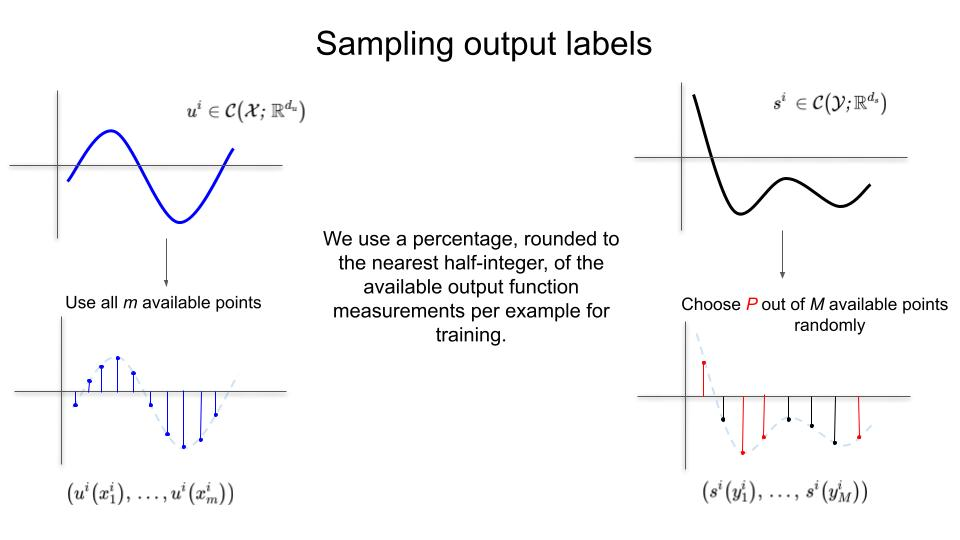


The LOCA implementation we provide assumes a fixed number of output measurements $P$, which is not as general.


For sampling the $P$ labels from the output domain we employ the function:

In [2]:
def output_construction(s,Y,P=100,ds=1, dy=2, N=1000,Nx=100,Ny=100):
    s = s.reshape(Nx,Ny, ds)
    Y = Y.reshape(Nx,Ny, dy)
    x = np.random.randint(Nx, size=P)
    y = np.random.randint(Ny, size=P)
    Y_all = Y[x][range(P), y, :]
    s_all = s[x][range(P), y, :]
    return s_all, Y_all

# Handling batches 

For fetching mini-batches during training, we will define a `DataGenerator` class, which performs two actions:

* Creates a random key each time that it is called,
* Randomly chooses batches of realizations from the data-set and returns a tuple containing the argumetns of the forward pass $\mathcal{F}(u^i)(y^i)$ and $s^i$ target functions for comparing with the prediction in the loss function. 

In [17]:
class DataGenerator(data.Dataset):
    def __init__(self, inputsxu, y, s, z, w,
                 batch_size=100, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.inputsxu  = inputsxu
        self.y = y
        self.s = s
        self.z = z
        self.w = w
        
        self.N = inputsxu.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    # @partial(jit, static_argnums=(0,))
    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs,outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:,:]
        inputsxu  = self.inputsxu[idx,:,:]
        y = self.y[idx,:,:]
        z = self.z[idx,:,:]
        w = self.w[idx,:,:]
        inputs = (inputsxu, y, z, w)
        return inputs, s

# Harmonic feature expansion

Lu _et. al._ proposed in their paper _"A comprehensive and fair comparison of two neural operators (with practical extensions) based on fair data."_ a technique called Harmonic Feature Expansion defined as:

$$(cos(2^0 \pi y), sin(2^0 \pi y), cos(2^1 \pi y), sin(2^1 \pi y),..., cos(2^H \pi y),sin(2^H \pi y))$$

which is then concatenated to the query locations. We perform the same augmentation with the input function samples. This process is performed for each dimension separately: 
$$e(y^i, 2j + (i-1)H  = cos(2^i \pi y^i) \\ 
e(y^i, 2j + 1+ (i-1)H = sin(2^i \pi y^i) $$

where $H$ the number of expansion coefficients, $j = 1,...,H/2$, $y^i$ the query coordinates in different spatial dimensions and $i = 1,...,d_y$. 

For this purpose, we create a vectorized function in JAX to apply the above efficiently to the whole dataset. 

The Harmonic Feature Expansion or other types of encodings, i.e. positional encodings in the Transformers literature, provide an intuitive way to include indirect positional information about the functions that are feeded to a neural network. This has been proven to be very effective in the Transformers literature and it is widely used. 

In learning for physics, positional encodings provide an intuitive way to handle different structures that might be present in a dataset that comes from some physical system, like periodic boundary conditions, oscillations, high frequencies, all at once. 

In [4]:
class HarmonicFeatureExpansionY:
    def __init__(self, Y, d_model, max_len = 100, H=20):
        self.d_model = int(np.ceil(d_model/4)*2)
        self.Y = Y
        self.max_len = max_len
        self.H = H

    @partial(jit, static_argnums=(0,))
    def forward(self, x):
        pex = np.zeros((x.shape[0], self.max_len, self.H))
        pey = np.zeros((x.shape[0], self.max_len, self.H))
        T = jnp.take(self.Y, 0, axis=2)[:,:,None]
        X = jnp.take(self.Y, 1, axis=2)[:,:,None]
        positionT = jnp.tile(T,(1,1,self.H))
        positionX = jnp.tile(X,(1,1,self.H))
        div_term = 2**jnp.arange(0,int(self.H/2),1)*jnp.pi
        pex = jax.ops.index_update(pex, jax.ops.index[:,:,0::2], jnp.cos(positionT[:,:,0::2] * div_term))
        pex = jax.ops.index_update(pex, jax.ops.index[:,:,1::2], jnp.sin(positionT[:,:,1::2] * div_term))
        pey = jax.ops.index_update(pey, jax.ops.index[:,:,0::2], jnp.cos(positionX[:,:,0::2] * div_term))
        pey = jax.ops.index_update(pey, jax.ops.index[:,:,1::2], jnp.sin(positionX[:,:,1::2] * div_term))
        pos_embedding =  jnp.concatenate((pex,pey),axis=-1) # [[x,pex],
                                                            # [y,pey]]
        x =  jnp.concatenate([x, pos_embedding], -1)
        return x

## Scattering Transform

The wavelet scattering transform is performed on the input functions

In [5]:
def scatteringTransform(sig, training_batch_size = 100):
    scattering = Scattering2D(J=1, L=3, max_order=2, shape=(32, 32))
    cwtmatr = np.zeros((training_batch_size, 768, 1))
    sig = np.array(sig)
    for i in range(0,training_batch_size):
        scatteringCoeffs = scattering(sig[i,:,:].reshape(32,32))
        cwtmatr[i,:,:] = scatteringCoeffs[:3,:,:].flatten()[:,None]
    return cwtmatr

## Auxiliary functions for kernel computation

Here we define some auxiliary functions to compute the square euclidean distance between two vectors.

In [6]:
def pairwise_distances(dist,**arg):
    return jit(vmap(vmap(partial(dist,**arg),in_axes=(None,0)),in_axes=(0,None)))

def euclid_distance(x,y):
    XX=jnp.dot(x,x)
    YY=jnp.dot(y,y)
    XY=jnp.dot(x,y)
    return XX+YY-2*XY

# Loss Functions

For training the model, we consider a relative $\mathcal{L}_2$ error loss: 
$$ \mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^P \frac{\| s^i(y_j^i) - \mathcal{G}(u^i)(y_j^i) \|^2_2}{\| s^i(y_j^i) \|^2_2}$$

as in the Fourier Neural Operators, which we will see in the next tutorial. The $\mathcal{L}_2$ loss function weights each component differently depending on the norm of the target function sample. 


One of the reason we employ this loss function is to to avoid biasing the model towards over-fitting to functions with larger magnitudes. Moreover, there has been a success of methods that consider adaptive weights to the loss function and this is a intuitive way to choose the weights.

In [7]:
class LpLoss(object):
    def __init__(self, d=2, p=2):
        super(LpLoss, self).__init__()
        self.d = d
        self.p = p

    def rel(self, x, y):
        num_examples = x.shape[0]
        diff_norms = jnp.linalg.norm(y.reshape(num_examples,-1) - x.reshape(num_examples,-1), self.p, 1)
        y_norms = jnp.linalg.norm(y.reshape(num_examples,-1), self.p, 1)
        return jnp.mean(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

Another choice of loss function is the mean squared error loss used throught the examples in the manuscript:

$$ \mathcal{L}(\theta) = \frac{1}{NP} \sum_{i=1}^N \sum_{j=1}^P \big ( s^i(y_j^i) - \mathcal{G}(u^i)(y_j^i)  \big ) ^2 $$



In [8]:
def loss(self, params, batch):
    inputs, outputs = batch
    y_pred = self.OKSA_net(params,inputs)
    loss = np.mean((outputs.flatten() - y_pred.flatten())**2)
    return loss    

# LOCA model implementation

At this point we will define a class which we will call LOCA and will contain the LOCA model definition, forward pass, the optimizer and the training loop. 

We will explain the important parts of this class:

Following the `stax` library syntax we define two pure function, one for the branch and one for the trunk network using the network initialization funtion `init_NN` which returns one apply and one initialization function. We define the input shapes as `(-1, q_layers[0])`,`(-1, v_layers[0])` and `(-1, g_layers[0])` to indicate that we want the function to be vectorized in every dimension except for the last. Remember $v$ has shape $N_{samples} \times 1 \times d_u*m$ and $\varphi$ has shape $N_{samples} \times P \times d_y$.

```
self.q_init, self.q_apply = self.init_NN(q_layers, activation=Gelu)
self.in_shape = (-1, q_layers[0])
self.out_shape, q_params = self.q_init(random.PRNGKey(10000), self.in_shape)

self.v_init, self.v_apply = self.init_NN(v_layers, activation=Gelu)
self.in_shape = (-1, v_layers[0])
self.out_shape, v_params = self.v_init(random.PRNGKey(10000), self.in_shape)

self.g_init, self.g_apply = self.init_NN(g_layers, activation=Gelu)
self.in_shape = (-1, g_layers[0])
self.out_shape, g_params = self.g_init(random.PRNGKey(10000), self.in_shape)

```


We discussed on the start of the tutorial how the LOCA method works for one query coordinate $y^i_l$. The forward pass presented below follows is exactly this process vectorized to handled $P$ points at the same time. 

```
def LOCA_net(self, params, inputs, ds=1):
      # Get model parameters
      beta, gamma, q_params, g_params, v_params = params
      # Get inputs from data generator
      u, y, z, w = inputs
      # Get q(y) and q(z)
      inputsy  = self.q_apply(q_params,y)
      inputsz  = self.q_apply(q_params,z)

      # Get k = -\beta \exp( - gamma ||q(z) - q(z)||^2)
      K =  self.RBF(z, z, gamma, beta)
      Kzz =  jnp.sqrt(self.jac_det*jnp.einsum("ijk,ikl->ijl",K,w))
      # Compute \sqrt(\int k(z, z) dz) for normalizing the kernel
      Kzz =  jnp.sqrt(self.jac_det*jnp.einsum("ijk,ikl->ijl",K,w))

      # Get k = -\beta \exp( - gamma ||q(y) - q(z)||^2)
      # Compute \sqrt(\int k(y, z) dz) for normalizing the kernel
      K =  self.RBF(y, z, gamma, beta)
      Kyz =  jnp.sqrt(self.jac_det*jnp.einsum("ijk,ikl->ijl",K,w))
      mean_K = jnp.matmul(Kyz, jnp.swapaxes(Kzz,1,2))
      # Normalize the kernel
      K = jnp.divide(K,mean_K)

      # Compute g(z)
      g  = self.g_apply(g_params, inputsz)
      # Compute \tilde{g} = \int K(y,z) g(z) dz
      g = jnp.einsum("ijk,ikl,ikm->ijml",K,g,w)
      # Compute \varphi(y)
      g = jax.nn.softmax(g.reshape(g.shape[0],g.shape[1], ds, int(g.shape[-1]/ds)), axis=-1)

      # Compute v = f \circ \mathcal{D}(u)
      v = self.v_apply(v_params, u.reshape(u.shape[0],1,u.shape[1]*u.shape[2]))
      v = v.reshape(v.shape[0],int(v.shape[2]/ds),ds)
      # Compute the expectation \mathbb{E}_{\varphi(y)}[v(u)]
      Guy = jnp.einsum("ijkl,ilk->ijk", g,v)
      return Guy
```

The way the other functions work is self explanatory, therefore we will not go into details.

The whole `LOCA` model class is presented below:

In [9]:
class LOCA:
    def __init__(self, q_layers, g_layers, v_layers , m=100, P=100, jac_det=None):    
        # Network initialization and evaluation functions
        self.q_init, self.q_apply = self.init_NN(q_layers, activation=Gelu)
        self.in_shape = (-1, q_layers[0])
        self.out_shape, q_params = self.q_init(random.PRNGKey(10000), self.in_shape)

        self.v_init, self.v_apply = self.init_NN(v_layers, activation=Gelu)
        self.in_shape = (-1, v_layers[0])
        self.out_shape, v_params = self.v_init(random.PRNGKey(10000), self.in_shape)
        self.v_apply = jit(self.v_apply)

        self.g_init, self.g_apply = self.init_NN(g_layers, activation=Gelu)
        self.in_shape = (-1, g_layers[0])
        self.out_shape, g_params = self.g_init(random.PRNGKey(10000), self.in_shape)
        self.g_apply = jit(self.g_apply)

        # RBF kernel parameters
        beta = [10.]
        gamma = [0.2]

        # Model parameters
        params = (beta, gamma,q_params, g_params, v_params)

        self.jac_det = jac_det

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init,self.opt_update,self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=100, 
                                                                      decay_rate=0.99))
        self.opt_state = self.opt_init(params)
        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

        self.grads = []

        self.vdistance_function = vmap(pairwise_distances(euclid_distance))

    def init_NN(self, Q, activation=Gelu):
        layers = []
        num_layers = len(Q)
        if num_layers < 2:
            net_init, net_apply = stax.serial()
        else:
            for i in range(0, num_layers-2):
                layers.append(Dense(Q[i+1]))
                layers.append(activation)
            layers.append(Dense(Q[-1]))
            net_init, net_apply = stax.serial(*layers)
        return net_init, net_apply


    @partial(jax.jit, static_argnums=0)
    def RBF(self, X, Y, gamma, beta):
        d = self.vdistance_function(X, Y)
        return beta[0]*jnp.exp(-gamma[0]*d) 

    @partial(jax.jit, static_argnums=0)
    def Mattern_32(self, X, Y, gamma, beta):
        d = self.vdistance_function(X, Y)
        return (1 + (jnp.sqrt(3)*gamma[0])*d)*beta[0]*jnp.exp(-(jnp.sqrt(3)*gamma[0])*d)

    @partial(jax.jit, static_argnums=0)
    def Mattern_52(self, X, Y, gamma, beta):
        d = self.vdistance_function(X, Y)
        return (1 + (jnp.sqrt(5)*gamma[0])*d + (5/3*gamma[0])*d**2)*beta[0]*jnp.exp(-(jnp.sqrt(5)*gamma[0])*d)

    @partial(jax.jit, static_argnums=0)
    def periodic(self, X, Y, gamma, beta):
        d = self.vdistance_function(X, Y)
        return jnp.exp(-2.0*jnp.sin(jnp.pi*d*beta[0])*gamma[0]**2)

    @partial(jax.jit, static_argnums=0)
    def RQK(self, X, Y, gamma, beta):
        d = self.vdistance_function(X, Y)
        return beta[0]*(1 + (1./3.)*gamma[0]*d)**(gamma[0]) 

    def LOCA_net(self, params, inputs, ds=1):
        # Get model parameters
        beta, gamma, q_params, g_params, v_params = params
        # Get inputs from data generator
        u, y, z, w = inputs
        # Get q(y) and q(z)
        inputsy  = self.q_apply(q_params,y)
        inputsz  = self.q_apply(q_params,z)

        # Get k = -\beta \exp( - gamma ||q(z) - q(z)||^2)
        K =  self.RBF(z, z, gamma, beta)
        Kzz =  jnp.sqrt(self.jac_det*jnp.einsum("ijk,ikl->ijl",K,w))
        # Compute \sqrt(\int k(z, z) dz) for normalizing the kernel
        Kzz =  jnp.sqrt(self.jac_det*jnp.einsum("ijk,ikl->ijl",K,w))

        # Get k = -\beta \exp( - gamma ||q(y) - q(z)||^2)
        # Compute \sqrt(\int k(y, z) dz) for normalizing the kernel
        K =  self.RBF(y, z, gamma, beta)
        Kyz =  jnp.sqrt(self.jac_det*jnp.einsum("ijk,ikl->ijl",K,w))
        mean_K = jnp.matmul(Kyz, jnp.swapaxes(Kzz,1,2))
        # Normalize the kernel
        K = jnp.divide(K,mean_K)

        # Compute g(z)
        g  = self.g_apply(g_params, inputsz)
        # Compute \tilde{g} = \int K(y,z) g(z) dz
        g = jnp.einsum("ijk,ikl,ikm->ijml",K,g,w)
        # Compute \varphi(y)
        g = jax.nn.softmax(g.reshape(g.shape[0],g.shape[1], ds, int(g.shape[-1]/ds)), axis=-1)

        # Compute v = f \circ \mathcal{D}(u)
        v = self.v_apply(v_params, u.reshape(u.shape[0],1,u.shape[1]*u.shape[2]))
        v = v.reshape(v.shape[0],int(v.shape[2]/ds),ds)
        # Compute the expectation \mathbb{E}_{\varphi(y)}[v(u)]
        Guy = jnp.einsum("ijkl,ilk->ijk", g,v)
        return Guy


    @partial(jax.jit, static_argnums=0)
    def loss(self, params, batch):
        inputs, outputs = batch
        y_pred = self.LOCA_net(params,inputs)
        loss = np.mean((outputs.flatten() - y_pred.flatten())**2)
        return loss    

    @partial(jax.jit, static_argnums=0)
    def lossT(self, params, batch):
        inputs, outputs = batch
        y_pred = self.LOCA_net(params,inputs)
        loss = np.mean((outputs.flatten() - y_pred.flatten())**2)
        return loss    
    
    @partial(jax.jit, static_argnums=0)
    def L2errorT(self, params, batch):
        inputs, y = batch
        y_pred = self.LOCA_net(params,inputs)
        return norm(y_pred.flatten() - y.flatten(), 2)/norm(y_pred.flatten(),2)

    @partial(jax.jit, static_argnums=0)
    def L2error(self, params, batch):
        inputs, y = batch
        y_pred = self.LOCA_net(params,inputs)
        return norm(y_pred.flatten() - y.flatten(), 2)/norm(y_pred.flatten(),2)
    
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state), g

    def train(self, train_dataset, test_dataset, nIter = 10000):
        train_data = iter(train_dataset)
        test_data  = iter(test_dataset)

        pbar = trange(nIter)
        for it in pbar:
            train_batch = next(train_data)
            test_batch  = next(test_data)

            self.opt_state, g = self.step(next(self.itercount), self.opt_state, train_batch)

            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                self.grads.append(g)

                loss_train = self.loss(params, train_batch)
                loss_test  = self.lossT(params, test_batch)

                errorTrain = self.L2error(params, train_batch)
                errorTest  = self.L2errorT(params, test_batch)

                self.loss_log.append(loss_train)

                pbar.set_postfix({'Training loss': loss_train, 
                                  'Testing loss' : loss_test,
                                  'Test error':    errorTest,
                                  'Train error':   errorTrain})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        s_pred = self.LOCA_net(params,inputs)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predictT(self, params, inputs):
        s_pred = self.LOCA_net(params,inputs)
        return s_pred
        
    def count_params(self):
        params = self.get_params(self.opt_state)
        params_flat, _ = ravel_pytree(params)
        print("The number of model parameters is:",params_flat.shape[0])

# Helper functions for prediction and error computation

We employ two helper functions, one for making predictions for the full resolution of the dataset and one for computing the error between the target and the predicted full resolution solution. 

In the predict function, we need to apply the harmonic feature expansion to the whole spatial grid for all realizations. This is handled by the `HarmonicFeatureExpansion` class presented previously. The input function samples are re-used.

In [10]:
def predict_function(U_in, Y_in, num_test=200, Nx=30, Ny=32,model=None,params= None, H=20, z= None, w=None):
    print("Predicting the solution for the full resolution")
    y = np.expand_dims(Y_in,axis=0)
    y = np.tile(y,(num_test,1,1))
    u = jnp.asarray(scatteringTransform(U_in, training_batch_size=num_test))
    pos_encodingy = HarmonicFeatureExpansionY(y,int(y.shape[1]*y.shape[2]), max_len = Nx*Ny, H=H)
    y  = pos_encodingy.forward(y)
    u_super_all = model.predict(params, (u,y, z, w))
    return u_super_all


def error_full_resolution(uCNN_super_all, s_all,tag='train', num_train=1000, P=128, Nx=32, Ny=32):
    test_error_u = []
    z = uCNN_super_all.reshape(num_train,Nx,Ny)
    s = s_all.reshape(num_train,Nx,Ny)
    for i in range(0,num_train):
        test_error_u.append(norm(s[i,:,:]- z[i,:,:], 2)/norm(s[i,:,:], 2))
    print("The average "+tag+" u error for the super resolution is %e, the standard deviation %e, the minimum error is %e and the maximum error is %e"%(np.mean(test_error_u),np.std(test_error_u),np.min(test_error_u),np.max(test_error_u)))
    absolute_error = np.abs(z-s)
    return absolute_error, np.mean(test_error_u), test_error_u

# Main part of the model

## Importing the training and testing datasets

We present the main part of the function that implements the DeepONet architecture. 

First we load the data and randomly choose output labels:

In [11]:
TRAINING_ITERATIONS = 20000
P = 128
m = 1024
num_train = 1000
num_test  = 1000
casenum_train = 2
casenum_test  = 2
training_batch_size = 100
dx = 2
du = 1
dy = 2
ds = 1
n_hat  = 100
l  = 100
Nx = 32
Ny = 32
H = 6

d = np.load("../Data/train_darcy_dataset.npz")
U_train   = d["U_train"]
Y_train   = d["Y_train"]
S_train   = d["s_train"]

d = np.load("../Data/test_darcy_dataset.npz")
U_test   = d["U_test"]
Y_test   = d["Y_test"]
S_test   = d["s_test"]

polypoints = 14
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])

# GLL nodes and weights in [-1,1]        
z1, w1 = leggauss(polypoints)
z2, w2 = leggauss(polypoints)

# Rescale nodes to [lb,ub]
x1 = 0.5*(ub[0] - lb[0])*(z1 + 1.0) + lb[0]
x2 = 0.5*(ub[1] - lb[1])*(z2 + 1.0) + lb[1]

# Determinant of Jacobian of mapping [lb,ub]-->[-1,1]^2
jac_det = 0.5**2 * (ub[0]-lb[0]) * (ub[1]-lb[1])

Z_1, Z_2 = np.meshgrid(z1,z2,indexing="ij")

Z = np.concatenate((Z_1.flatten()[:,None], Z_2.flatten()[:,None]), axis=-1)
Z = np.tile(Z,(num_train,1,1))

W = np.outer(w1, w2).flatten()[:,None]
W = np.tile(W,(num_train,1,1))

polypoints = polypoints**dy

Y_train_in = Y_train
Y_test_in = Y_test

s_all_test = S_test[:num_test,:]
s_all_train = S_train[:num_train,:]

s_train = np.zeros((num_train,P,ds))
y_train = np.zeros((num_train,P,dy))

s_test = np.zeros((num_test,P,ds))
y_test = np.zeros((num_test,P,dy))

for i in range(0,num_train):
    s_train[i,:,:], y_train[i,:,:] = output_construction(S_train[i,:], Y_train, Nx=Nx, Ny=Ny, P=P, ds=ds)

for i in range(num_test):
    s_test[i,:,:], y_test[i,:,:] = output_construction(S_test[i,:], Y_test, Nx=Nx, Ny=Ny, P=P, ds=ds)

## Transforming them to JAX arrays

Then we transform the NumPy arrays into JAX DeviceArrays:

In [12]:
y_train_pos = y_train
y_train_posT = y_test

U_train = np.asarray(U_train)
y_train = jnp.asarray(y_train)
s_train = jnp.asarray(s_train)

U_test = np.asarray(U_test)
y_test = jnp.asarray(y_test)
s_test = jnp.asarray(s_test)

z = jnp.asarray(Z)
w = jnp.asarray(W)

U_train = np.reshape(U_train,(num_train,m,du))
y_train = jnp.reshape(y_train,(num_train,P,dy))
s_train = jnp.reshape(s_train,(num_train,P,ds))

U_test = np.reshape(U_test,(num_test,m,du))
y_test = jnp.reshape(y_test,(num_test,P,dy))
s_test = jnp.reshape(s_test,(num_test,P,ds))

z = jnp.reshape(z,(num_test,polypoints,dy))
w = jnp.reshape(w,(num_test,polypoints,1))

## Applying the Harmonic Feature Expansion

Apply the Harmonic Feature Expansion to both the output query points and the input function samples:

In [13]:
pos_encodingy  = HarmonicFeatureExpansionY(y_train_pos,int(y_train_pos.shape[1]*y_train_pos.shape[2]), max_len = P, H=H)
y_train  = pos_encodingy.forward(y_train)
del pos_encodingy

pos_encodingy  = HarmonicFeatureExpansionY(z,int(z.shape[1]*z.shape[2]), max_len = polypoints, H=H)
z  = pos_encodingy.forward(z)
del pos_encodingy

pos_encodingyt = HarmonicFeatureExpansionY(y_train_posT,int(y_train_posT.shape[1]*y_train_posT.shape[2]), max_len = P, H=H)
y_test   = pos_encodingyt.forward(y_test)
del pos_encodingyt

## Apply scattering transform

In [14]:
inputs_trainxu = jnp.asarray(scatteringTransform(U_train, training_batch_size=num_train))
inputs_testxu  = jnp.asarray(scatteringTransform(U_test , training_batch_size=num_test))

## Handling mini-batches

Pass the train and testing dataset to the DataGenerator class for creating mini-batches during training:

In [19]:
train_dataset = DataGenerator(inputs_trainxu, y_train, s_train, z, w, training_batch_size)
train_dataset = iter(train_dataset)

test_dataset = DataGenerator(inputs_testxu, y_test, s_test, z, w, training_batch_size)
test_dataset = iter(test_dataset)

## Choosing the model architecture

Define the network architecture and the model class:

In [20]:
q_layers = [dy+H*dy, 100, 100, l]
v_layers = [768*du, 100, 100, ds*n_hat]
g_layers = [l, 100, 100, ds*n_hat]

# Define model
model = LOCA(q_layers, g_layers, v_layers, m=m, P=P, jac_det=jac_det)

model.count_params()

The number of model parameters is: 149102


## Training the model

Train the model and compute the wall-clock time needed for training:

In [21]:
start_time = timeit.default_timer()
model.train(train_dataset, test_dataset, nIter=TRAINING_ITERATIONS)
elapsed = timeit.default_timer() - start_time
print("The training wall-clock time is seconds is equal to %f seconds"%elapsed)

100%|██████████| 20000/20000 [01:06<00:00, 302.85it/s, Training loss=1.9843934e-05, Testing loss=3.766751e-05, Test error=0.010893683, Train error=0.007880603]  

The training wall-clock time is seconds is equal to 66.042935 seconds


## Making predictions and computing the error

Use the model parameters to make predictions:

In [22]:
params = model.get_params(model.opt_state)

u_super_all_train  = predict_function(U_train, Y_train_in, model=model,Nx=Nx,Ny=Ny, params=params, H=H, z=z, w=w, num_test=num_train)
u_super_all_test   = predict_function(U_test,  Y_test_in, model=model, Nx=Nx,Ny=Ny, params=params, H=H, z=z, w=w, num_test=num_test)

absolute_error_test, mean_test_error, test_error     = error_full_resolution(u_super_all_test,  s_all_test,  tag='test', P=P, Nx=Nx, Ny=Ny, num_train=num_train)
absolute_error_train, mean_train_error, train_error  = error_full_resolution(u_super_all_train, s_all_train, tag='train',P=P, Nx=Nx, Ny=Ny, num_train=num_test)

Predicting the solution for the full resolution
Predicting the solution for the full resolution
The average test u error for the super resolution is 6.654071e-03, the standard deviation 2.036762e-03, the minimum error is 3.092691e-03 and the maximum error is 1.813675e-02
The average train u error for the super resolution is 4.552601e-03, the standard deviation 8.058764e-04, the minimum error is 2.746602e-03 and the maximum error is 8.351138e-03


Save the model parameters

In [23]:
# Save trained model parameters
saveParameters = True
if saveParameters:
    opt_params_flat, _ = ravel_pytree(params)
    np.save("LOCA_parameters.npy", opt_params_flat)

## End of tutorial